In [5]:
import networkx as nx
import igraph as ig
import rustworkx as rx
import time
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
def load_dimacs_graph(filename):
    """Load a DIMACS format .gr file and return as NetworkX, igraph, and rustworkx graphs"""
    
    # Parse the file
    nodes = set()
    edges = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('a '):  # Edge line
                parts = line.split()
                source, target, weight = int(parts[1]), int(parts[2]), int(parts[3])
                nodes.add(source)
                nodes.add(target)
                edges.append((source, target, weight))
            elif line.startswith('p sp'):  # Problem line
                parts = line.split()
                num_nodes, num_edges = int(parts[2]), int(parts[3])
    
    # Create NetworkX graph
    G_nx = nx.DiGraph()
    for source, target, weight in edges:
        G_nx.add_edge(source, target, weight=weight)
    
    # Create igraph graph
    G_ig = ig.Graph(directed=True)
    node_list = sorted(nodes)
    node_map = {node: idx for idx, node in enumerate(node_list)}
    G_ig.add_vertices(len(node_list))
    G_ig.add_edges([(node_map[s], node_map[t]) for s, t, w in edges])
    G_ig.es['weight'] = [w for s, t, w in edges]
    
    # Create rustworkx graph
    G_rx = rx.PyDiGraph()
    rx_node_map = {}
    for node in node_list:
        rx_node_map[node] = G_rx.add_node(node)
    for source, target, weight in edges:
        G_rx.add_edge(rx_node_map[source], rx_node_map[target], weight)
    
    return G_nx, G_ig, G_rx

rome_nx, rome_ig, rome_rx = load_dimacs_graph('rome99.gr')
ny_nx, ny_ig, ny_rx = load_dimacs_graph('USA-road-d.NY.gr')
e_nx, e_ig, e_rx = load_dimacs_graph('USA-road-d.E.gr')

PageRank times (seconds):
  NetworkX: 20.9045s
  NetworkX+CPP: 9.1675s
  igraph: 3.1554s
  rustworkx: 2.8305s


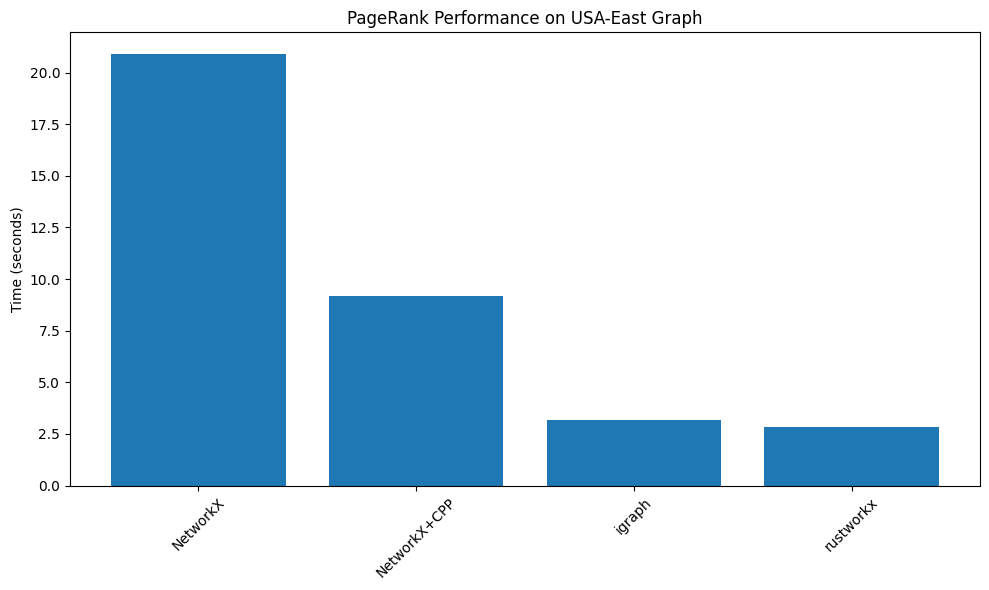

In [7]:
# PageRank
times = {}

# NetworkX (pure Python)
start = time.time()
_ = nx.pagerank(e_nx)
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = nx.pagerank(e_nx, backend="cpp")
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = e_ig.pagerank()
times['igraph'] = time.time() - start

# rustworkx
start = time.time()
_ = rx.pagerank(e_rx)
times['rustworkx'] = time.time() - start

# Display results
print("PageRank times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title('PageRank Performance on USA-East Graph')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BFS Edges times (seconds):
  NetworkX: 10.7656s
  NetworkX+CPP: 22.0088s
  igraph: 1.5595s
  rustworkx: 10.7108s


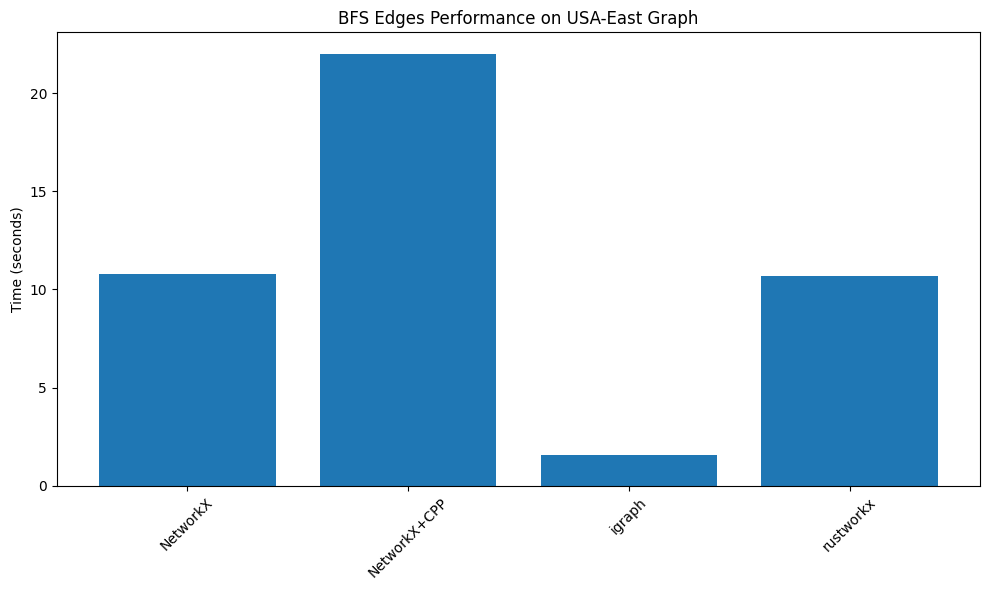

In [16]:
# BFS Edges
times = {}

# NetworkX (pure Python)
source = next(iter(e_nx.nodes))
start = time.time()
_ = list(nx.bfs_edges(e_nx, source))
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = list(nx.bfs_edges(e_nx, source, backend="cpp"))
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = list(e_ig.bfsiter(0, advanced=True))
times['igraph'] = time.time() - start

# rustworkx
rx_source = next(iter(e_rx.nodes()))
start = time.time()
_ = list(rx.bfs_successors(e_rx, rx_source))
times['rustworkx'] = time.time() - start

# Display results
print("BFS Edges times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title('BFS Edges Performance on USA-East Graph')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# DFS Edges
times = {}

# NetworkX (pure Python)
source = next(iter(e_nx.nodes))
start = time.time()
_ = list(nx.dfs_edges(e_nx, source))
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = list(nx.dfs_edges(e_nx, source, backend="cpp"))
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = list(e_ig.dfsiter(0, advanced=True))
times['igraph'] = time.time() - start

# rustworkx
rx_source = next(iter(e_rx.nodes()))
start = time.time()
_ = list(rx.dfs_edges(e_rx, rx_source))
times['rustworkx'] = time.time() - start

# Display results
print("DFS Edges times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title('DFS Edges Performance on USA-East Graph')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

TypeError: dfs_edges() got an unexpected keyword argument 'sort_neighbors'

In [19]:
# Shortest Path
times = {}

# Pick source and target
source = next(iter(e_nx.nodes))
bfs_nodes = [source] + [v for _, v in nx.bfs_edges(e_nx, source)]
target = bfs_nodes[-1] if bfs_nodes else source

# NetworkX (pure Python)
start = time.time()
_ = nx.shortest_path(e_nx, source=source, target=target, weight="weight", method="dijkstra")
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = nx.shortest_path(e_nx, source=source, target=target, weight="weight", method="dijkstra", backend="cpp")
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = e_ig.get_shortest_path(0, len(e_ig.vs)-1, weights='weight')
times['igraph'] = time.time() - start

# rustworkx
rx_source = next(iter(e_rx.nodes()))
rx_nodes = list(e_rx.nodes())
rx_target = rx_nodes[-1] if rx_nodes else rx_source
start = time.time()
_ = rx.dijkstra_shortest_paths(e_rx, rx_source, target=rx_target, weight_fn=lambda e: e)
times['rustworkx'] = time.time() - start

# Display results
print("Shortest Path times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title('Shortest Path (Dijkstra) Performance on USA-East Graph')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Betweenness Centrality times (seconds):
  NetworkX: 28.6592s
  NetworkX+CPP: 0.0640s
  igraph: 0.2921s
  rustworkx: 0.4380s


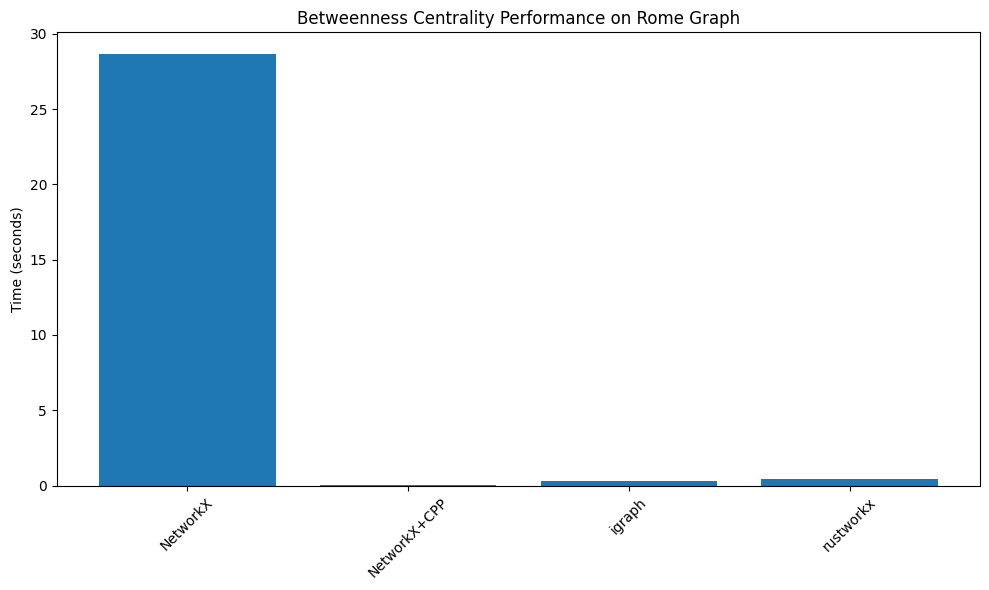

In [21]:
# Betweenness Centrality
times = {}

# NetworkX (pure Python)
start = time.time()
_ = nx.betweenness_centrality(rome_nx)
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = nx.betweenness_centrality(rome_nx, backend="cpp")
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = rome_ig.betweenness()
times['igraph'] = time.time() - start

# rustworkx
start = time.time()
_ = rx.betweenness_centrality(rome_rx)
times['rustworkx'] = time.time() - start

# Display results
print("Betweenness Centrality times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title('Betweenness Centrality Performance on Rome Graph')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Creating graphs...
Created graphs with 3000000 nodes
Created graphs with 3000000 nodes

Connected Components times (seconds):
  NetworkX: 1.5489s
  NetworkX+CPP: 4.5531s
  igraph: 0.2718s
  rustworkx: 0.2798s

Connected Components times (seconds):
  NetworkX: 1.5489s
  NetworkX+CPP: 4.5531s
  igraph: 0.2718s
  rustworkx: 0.2798s


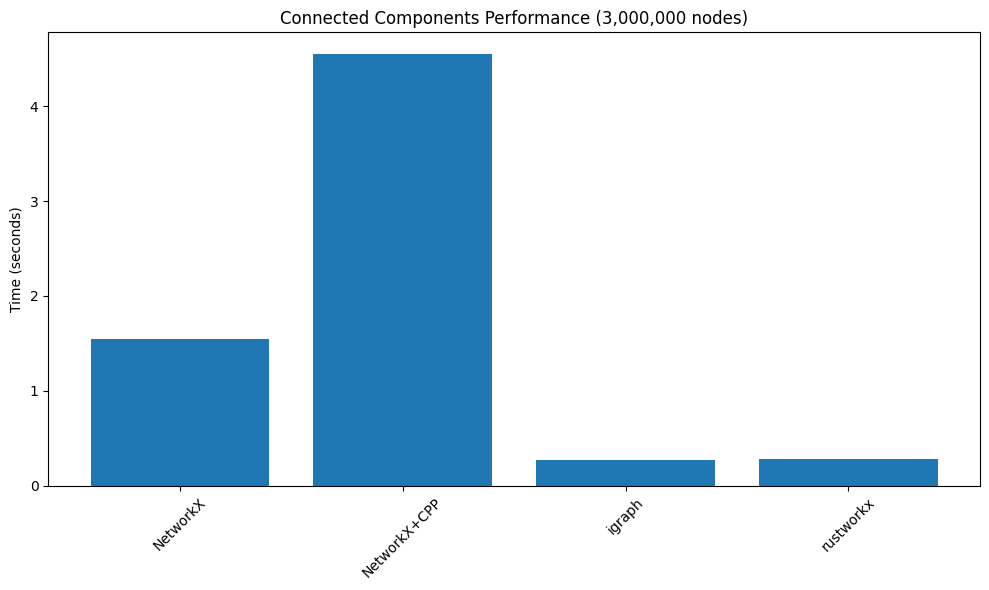

In [20]:
# Connected Components
def make_multi_component_path_graph_nx(num_components, component_size):
    G = nx.Graph()
    node_id = 0
    for _ in range(num_components):
        nodes = list(range(node_id, node_id + component_size))
        edges = [(nodes[i], nodes[i + 1]) for i in range(component_size - 1)]
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        node_id += component_size
    return G

def make_multi_component_path_graph_ig(num_components, component_size):
    G = ig.Graph()
    total_nodes = num_components * component_size
    G.add_vertices(total_nodes)
    
    edges = []
    node_id = 0
    for _ in range(num_components):
        for i in range(component_size - 1):
            edges.append((node_id + i, node_id + i + 1))
        node_id += component_size
    
    G.add_edges(edges)
    return G

def make_multi_component_path_graph_rx(num_components, component_size):
    G = rx.PyGraph()
    node_id = 0
    for _ in range(num_components):
        nodes = [G.add_node(node_id + i) for i in range(component_size)]
        for i in range(component_size - 1):
            G.add_edge(nodes[i], nodes[i + 1], None)
        node_id += component_size
    return G

num_components = 1000
component_size = 3000

print("Creating graphs...")
cc_nx = make_multi_component_path_graph_nx(num_components, component_size)
cc_ig = make_multi_component_path_graph_ig(num_components, component_size)
cc_rx = make_multi_component_path_graph_rx(num_components, component_size)
print(f"Created graphs with {num_components * component_size} nodes")

# Connected Components
times = {}

# NetworkX (pure Python)
start = time.time()
_ = list(nx.connected_components(cc_nx))
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = list(nx.connected_components(cc_nx, backend="cpp", method="bfs"))
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = cc_ig.connected_components()
times['igraph'] = time.time() - start

# rustworkx
start = time.time()
_ = rx.connected_components(cc_rx)
times['rustworkx'] = time.time() - start

# Display results
print("\nConnected Components times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title(f'Connected Components Performance ({num_components * component_size:,} nodes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Creating weighted random graphs...
Created graphs with 20000 nodes
Created graphs with 20000 nodes

Minimum Spanning Tree times (seconds):
  NetworkX: 0.2482s
  NetworkX+CPP: 0.1517s
  igraph: 0.0165s
  rustworkx: 0.0085s

Minimum Spanning Tree times (seconds):
  NetworkX: 0.2482s
  NetworkX+CPP: 0.1517s
  igraph: 0.0165s
  rustworkx: 0.0085s


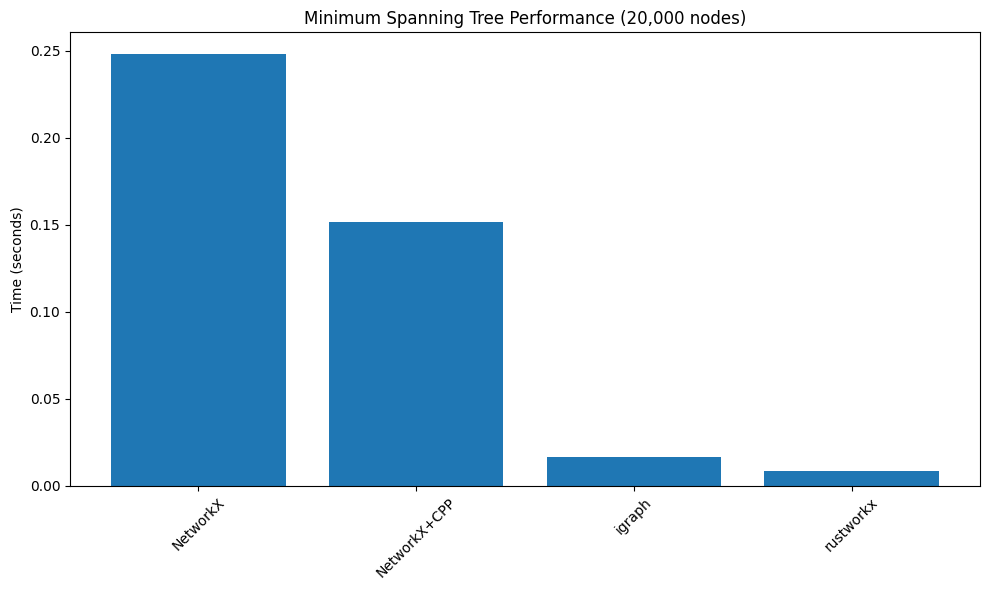

In [22]:
# Minimum Spanning Tree
def make_weighted_gnp_nx(n, p, rng_seed, weight_key="weight"):
    G = nx.gnp_random_graph(n, p, seed=rng_seed)
    for idx, (u, v) in enumerate(G.edges()):
        G[u][v][weight_key] = float(idx + 1)
    return G

def make_weighted_gnp_ig(n, p, rng_seed, weight_key="weight"):
    import random
    random.seed(rng_seed)
    G = ig.Graph.Erdos_Renyi(n=n, p=p)
    weights = [float(idx + 1) for idx in range(G.ecount())]
    G.es[weight_key] = weights
    return G

def make_weighted_gnp_rx(n, p, rng_seed):
    import random
    random.seed(rng_seed)
    G = rx.PyGraph()
    nodes = [G.add_node(i) for i in range(n)]
    
    # Generate edges with probability p
    edges = []
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                edges.append((i, j))
    
    for idx, (u, v) in enumerate(edges):
        G.add_edge(u, v, float(idx + 1))
    
    return G

n = 20000
p = 0.0005
rng_seed = 42

print("Creating weighted random graphs...")
mst_nx = make_weighted_gnp_nx(n, p, rng_seed)
mst_ig = make_weighted_gnp_ig(n, p, rng_seed)
mst_rx = make_weighted_gnp_rx(n, p, rng_seed)
print(f"Created graphs with {n} nodes")

# Minimum Spanning Tree
times = {}

# NetworkX (pure Python)
start = time.time()
_ = nx.minimum_spanning_tree(mst_nx, weight="weight")
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = nx.minimum_spanning_tree(mst_nx, weight="weight", algorithm="kruskal", backend="cpp")
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = mst_ig.spanning_tree(weights="weight")
times['igraph'] = time.time() - start

# rustworkx
start = time.time()
_ = rx.minimum_spanning_tree(mst_rx, weight_fn=lambda e: e)
times['rustworkx'] = time.time() - start

# Display results
print("\nMinimum Spanning Tree times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title(f'Minimum Spanning Tree Performance ({n:,} nodes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Creating subgraphs with 3000 nodes...
Created subgraphs

Isomorphism times (seconds):
  NetworkX: 22.2961s
  NetworkX+CPP: 0.0528s
  igraph: 0.0116s
  rustworkx: 0.0091s

Isomorphism times (seconds):
  NetworkX: 22.2961s
  NetworkX+CPP: 0.0528s
  igraph: 0.0116s
  rustworkx: 0.0091s


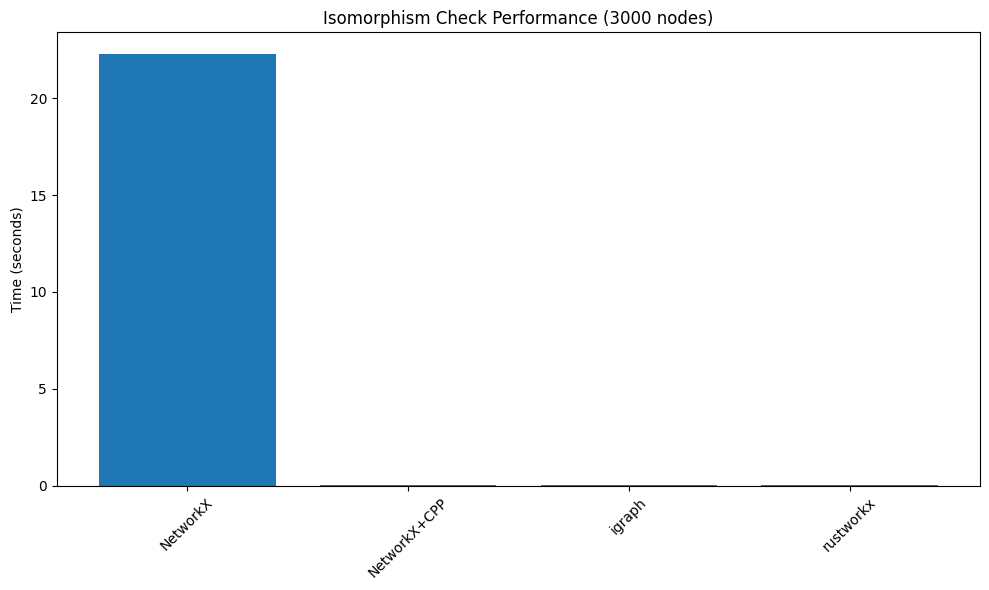

In [23]:
# Isomorphism
def induced_subgraph_first_n(G, n_nodes):
    """
    take the induced subgraph on the first n_nodes in G.nodes()
    """
    nodes = []
    for i, u in enumerate(G.nodes()):
        if i >= n_nodes:
            break
        nodes.append(u)
    return G.subgraph(nodes).copy()

sub_n = 3000
print(f"Creating subgraphs with {sub_n} nodes...")
G_sub_nx = induced_subgraph_first_n(ny_nx, sub_n)
G1_nx = G_sub_nx
G2_nx = G_sub_nx.copy()

# Create igraph subgraph
G_sub_ig = ny_ig.subgraph(list(range(min(sub_n, ny_ig.vcount()))))
G1_ig = G_sub_ig
G2_ig = G_sub_ig.copy()

# Create rustworkx subgraph
rx_nodes = list(ny_rx.nodes())[:sub_n]
G_sub_rx = ny_rx.subgraph(rx_nodes)
G1_rx = G_sub_rx
G2_rx = G_sub_rx.copy()

print(f"Created subgraphs")

# Isomorphism
times = {}

# NetworkX (pure Python)
start = time.time()
_ = nx.is_isomorphic(G1_nx, G2_nx)
times['NetworkX'] = time.time() - start

# NetworkX with C++ backend
start = time.time()
_ = nx.is_isomorphic(G1_nx, G2_nx, backend="cpp")
times['NetworkX+CPP'] = time.time() - start

# igraph
start = time.time()
_ = G1_ig.isomorphic(G2_ig)
times['igraph'] = time.time() - start

# rustworkx
start = time.time()
_ = rx.is_isomorphic(G1_rx, G2_rx)
times['rustworkx'] = time.time() - start

# Display results
print("\nIsomorphism times (seconds):")
for lib, t in times.items():
    print(f"  {lib}: {t:.4f}s")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(times.keys(), times.values())
plt.ylabel('Time (seconds)')
plt.title(f'Isomorphism Check Performance ({sub_n} nodes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()